**请注意，当前版本为可提交版本，需要注意几个地方**

**1、predict.py生成result.json时更改image_name为image_id**

**2、predict.py生成result.json时更改计算x、y的方式**

**3、提供picodet_l_640与320模型文件进行测试**


In [1]:
# 跑之前套件拉取PaddleDetection-2.5.0
!unzip /home/aistudio/data/data321138/dataset.zip -d  /home/aistudio/work
%cd ~
%cd PaddleDetection-2.5.0
!python setup.py install
!pip install -r requirements.txt

  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_043123.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_044314.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_044315.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_044316.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_048264.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_048265.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_048266.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_048500.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_048501.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_048502.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_048559.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label_048560.png  
  inflating: /home/aistudio/work/dataset/val/game_5/labels/label

In [2]:
import os
import json
import xml.etree.ElementTree as ET

def create_pascal_voc(filename, width, height, objects, save_path):
    annotation = ET.Element("annotation")
    ET.SubElement(annotation, "folder").text = "zdy"
    ET.SubElement(annotation, "filename").text = filename
    ET.SubElement(annotation, "path").text = save_path
    source = ET.SubElement(annotation, "source")
    ET.SubElement(source, "database").text = "Unknown"
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"
    ET.SubElement(annotation, "segmented").text = "0"
    for obj in objects:
        obj_elem = ET.SubElement(annotation, "object")
        ET.SubElement(obj_elem, "name").text = obj["name"]
        ET.SubElement(obj_elem, "pose").text = "Unspecified"
        ET.SubElement(obj_elem, "truncated").text = "0"
        ET.SubElement(obj_elem, "difficult").text = "0"
        bndbox = ET.SubElement(obj_elem, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(obj["xmin"])
        ET.SubElement(bndbox, "ymin").text = str(obj["ymin"])
        ET.SubElement(bndbox, "xmax").text = str(obj["xmax"])
        ET.SubElement(bndbox, "ymax").text = str(obj["ymax"])
    tree = ET.ElementTree(annotation)
    tree.write(save_path)

def convert_annotations(json_file, image_dir, output_img_dir, output_ann_dir, game_name, img_width=1920, img_height=1080, box_size=32):
    with open(json_file, 'r') as f:
        annotations = json.load(f)

    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_ann_dir, exist_ok=True)

    for frame_id, data in annotations.items():
        x, y = data["ball_position"]["x"], data["ball_position"]["y"]
        if x == -1 or y == -1:
            continue
        xmin = max(0, x - box_size // 2)
        ymin = max(0, y - box_size // 2)
        xmax = min(img_width, x + box_size // 2)
        ymax = min(img_height, y + box_size // 2)
        objects = [{"name": "pinpang", "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax}]
        original_filename = f"frame_{int(frame_id):06d}.png"
        new_filename = f"{game_name}_{original_filename}"
        xml_filename = os.path.join(output_ann_dir, f"{game_name}_frame_{int(frame_id):06d}.xml")
        img_src_path = os.path.join(image_dir, original_filename)
        img_dest_path = os.path.join(output_img_dir, new_filename)
        create_pascal_voc(new_filename, img_width, img_height, objects, xml_filename)
        if os.path.exists(img_src_path):
            os.rename(img_src_path, img_dest_path)

def process_directory(train_dir):
    output_img_dir = os.path.join(train_dir, "JPEGImages")
    output_ann_dir = os.path.join(train_dir, "Annotations")
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_ann_dir, exist_ok=True)
    for game_folder in os.listdir(train_dir):
        game_path = os.path.join(train_dir, game_folder)
        if os.path.isdir(game_path) and game_folder.startswith("game_"):
            json_file = os.path.join(game_path, "annotations.json")
            image_dir = os.path.join(game_path, "frames")
            if os.path.exists(json_file) and os.path.exists(image_dir):
                print(f"Processing {game_folder}...")
                convert_annotations(json_file, image_dir, output_img_dir, output_ann_dir, game_folder)
    print(f"All games processed! Images and annotations saved in {output_img_dir} and {output_ann_dir}.")

train_directory = "/home/aistudio/work/dataset/train"
process_directory(train_directory)
%cd ~
%cd /home/aistudio/work/dataset/train
!python3 /home/aistudio/work/tools/spilt_train.py
val_directory = "/home/aistudio/work/dataset/val"
process_directory(val_directory)
%cd ~
%cd /home/aistudio/work/dataset/val
!python3 /home/aistudio/work/tools/spilt_val.py

Processing game_3...
Processing game_5...
Processing game_2...
Processing game_4...
Processing game_1...
All games processed! Images and annotations saved in /home/aistudio/work/dataset/train/JPEGImages and /home/aistudio/work/dataset/train/Annotations.
/home/aistudio
/home/aistudio/work/dataset/train
Processing game_3...
Processing game_5...
Processing game_2...
Processing game_4...
Processing game_1...
All games processed! Images and annotations saved in /home/aistudio/work/dataset/val/JPEGImages and /home/aistudio/work/dataset/val/Annotations.
/home/aistudio
/home/aistudio/work/dataset/val


In [3]:
!cp /home/aistudio/ppq.yml /home/aistudio/PaddleDetection-2.5.0/configs/picodet
!cp /home/aistudio/voc_ppq.yml /home/aistudio/PaddleDetection-2.5.0/configs/datasets

In [5]:
# 训练
%cd ~
%cd PaddleDetection-2.5.0
!python tools/train.py -c configs/picodet/ppq.yml \
                        --use_vdl=true \
                        --vdl_log_dir=/home/aistudio/work/vdl_dir \
                        --eval \
                        -o save_dir=/home/aistudio/work/model


/home/aistudio
/home/aistudio/PaddleDetection-2.5.0
W0403 08:41:49.184715  2850 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 12.0, Runtime API Version: 11.2
W0403 08:41:49.188431  2850 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.
[04/03 08:41:51] ppdet.utils.checkpoint INFO: ['last_conv.weight'] in pretrained weight is not used in the model, and its will not be loaded
[04/03 08:41:51] ppdet.utils.checkpoint INFO: The shape [1000] in pretrained weight fc.bias is unmatched with the shape [160] in model head.conv_feat.se.0.fc.bias. And the weight fc.bias will not be loaded
[04/03 08:41:51] ppdet.utils.checkpoint INFO: The shape [1280, 1000] in pretrained weight fc.weight is unmatched with the shape [160, 160, 1, 1] in model head.conv_feat.se.0.fc.weight. And the weight fc.weight will not be loaded
[04/03 08:41:51] ppdet.utils.checkpoint INFO: The shape [1000] in pretrained weight fc.bias is unmatched with the shape [160] in model hea

In [6]:
# # 评估
%cd ~
%cd PaddleDetection-2.5.0
!python tools/eval.py -c configs/picodet/ppq.yml \
                    -o weights=/home/aistudio/work/model/ppq/best_model.pdparams \
                    # --classwise \

/home/aistudio
/home/aistudio/PaddleDetection-2.5.0
W0403 10:05:27.268260 20318 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 12.0, Runtime API Version: 11.2
W0403 10:05:27.271754 20318 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.
[04/03 10:05:29] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/work/model/ppq/best_model.pdparams
[04/03 10:05:35] ppdet.engine INFO: Eval iter: 0
[04/03 10:05:41] ppdet.metrics.metrics INFO: Accumulating evaluatation results...
[04/03 10:05:41] ppdet.metrics.metrics INFO: mAP(0.50, 11point) = 90.91%
[04/03 10:05:41] ppdet.engine INFO: Total sample number: 434, averge FPS: 36.185063433412665


In [2]:

# 推理
%cd ~
%cd PaddleDetection-2.5.0
!python tools/infer.py -c configs/picodet/ppq.yml \
                    --infer_img=/home/aistudio/work/dataset/val/JPEGImages/game_1_frame_012375.png \
                    -o weights=/home/aistudio/work/model/ppq/best_model.pdopt \
                    --output_dir=/home/aistudio/work/img

/home/aistudio
/home/aistudio/PaddleDetection-2.5.0
W0405 17:00:34.321158  1370 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.2
W0405 17:00:34.325522  1370 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.
[04/05 17:00:36] ppdet.utils.checkpoint INFO: Finish loading model weights: /home/aistudio/work/model/ppq/best_model.pdparams
100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]
[04/05 17:00:38] ppdet.engine INFO: Detection bbox results save in /home/aistudio/work/img/game_1_frame_012375.png


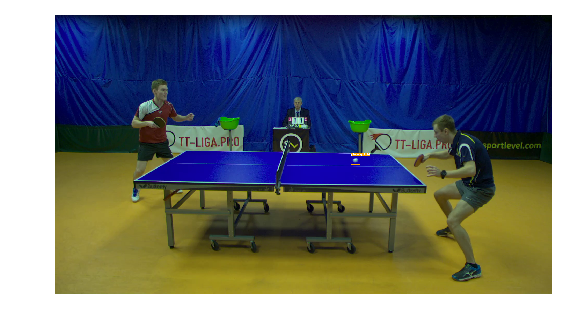

In [9]:
import matplotlib.pyplot as plt
import cv2

# 读取图像
image_path = "/home/aistudio/work/img/game_1_frame_012375.png"
image = cv2.imread(image_path)

# 检查图像是否成功加载
if image is None:
    print(f"Failed to load image: {image_path}")
else:
    # 转换 BGR 到 RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 显示图像
    plt.imshow(image)
    plt.axis("off")  # 关闭坐标轴
    plt.show()


In [ ]:
%cd ~
%cd PaddleDetection-2.5.0
!python tools/export_model.py -c configs/picodet/ppq.yml \
                    -o weights=/home/aistudio/work/model/ppq/best_model.pdopt \
                    --output_dir=/home/aistudio/work/export_model

In [11]:
%cd ~
!mkdir -p submission/PaddleDetection/deploy/python
!mkdir -p submission/model
!cp /home/aistudio/PaddleDetection-2.5.0/deploy/python/keypoint_preprocess.py /home/aistudio/submission/PaddleDetection/deploy/python/keypoint_preprocess.py
!cp /home/aistudio/PaddleDetection-2.5.0/deploy/python/preprocess.py /home/aistudio/submission/PaddleDetection/deploy/python/preprocess.py
!cp /home/aistudio/PaddleDetection-2.5.0/deploy/python/utils.py /home/aistudio/submission/PaddleDetection/deploy/python/utils.py
!cp /home/aistudio/predict.py /home/aistudio/submission/predict.py
!touch /home/aistudio/submission/PaddleDetection/deploy/python/__init__.py
!cp -r /home/aistudio/work/export_model/ppq/* ~/submission/model/

/home/aistudio


In [12]:
# 修改/home/aistudio/submission/PaddleDetection/deploy/python/preprocess.py的from keypoint_preprocess import get_affine_transform为
# from .keypoint_preprocess import get_affine_transform
import os

file_path = "/home/aistudio/submission/PaddleDetection/deploy/python/preprocess.py"

def modify_import_statement(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    modified_lines = [
        line.replace("from keypoint_preprocess import get_affine_transform", "from .keypoint_preprocess import get_affine_transform")
        if "from keypoint_preprocess import get_affine_transform" in line else line
        for line in lines
    ]
    with open(file_path, 'w') as f:
        f.writelines(modified_lines)
modify_import_statement(file_path)

In [13]:
import os  
# 指定要搜索的文件夹路径  
folder_path = "/home/aistudio/work/dataset/val/JPEGImages"  
# 指定要写入的txt文件路径  
output_file = "/home/aistudio/submission/output.txt"
# 获取文件夹下的所有文件和子文件夹  
files = os.listdir(folder_path)
# 打开txt文件准备写入  
with open(output_file, "w") as file:  
    # 遍历所有文件和子文件夹  
    for item in files:  
        # 如果不是文件夹，则写入文件路径到txt文件中  
        if not os.path.isdir(os.path.join(folder_path, item)):  
            file.write(os.path.join(folder_path, item) + "\n")

在测试时请务必注意result.json的格式，对齐为


[{'image_id': 'xxx.png', 'type': 'pinpang', 'x': 969.5622253417969, 'y': 536.7064819335938, 'width': 36.44512939453125, 'height': 30.5203857421875, 'segmentation': []}

In [ ]:
# 可能耗时较长，40s-100s不等
%cd ~/submission
!python3 predict.py output.txt result.json

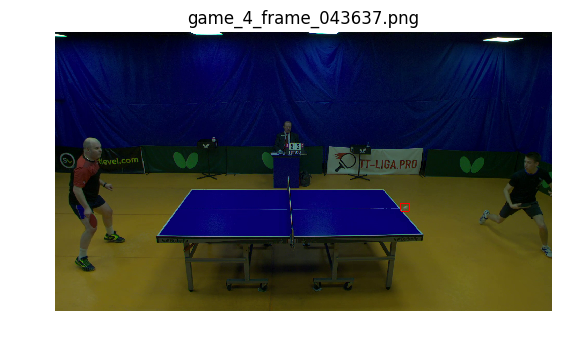

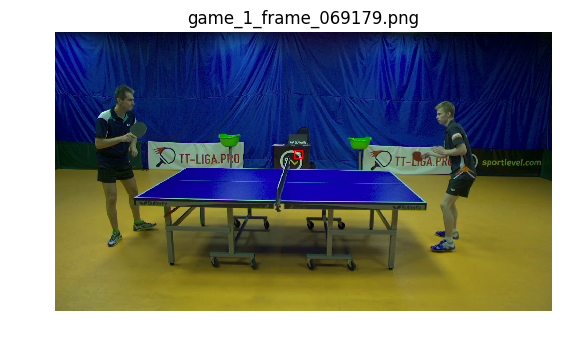

In [15]:
import json
import os
import cv2
import matplotlib.pyplot as plt

def draw_bboxes(json_file, image_folder):
    # 读取JSON文件
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # 获取前10个检测结果
    results = data['result'][:2]
    
    for res in results:
        image_id = res['image_id']
        x, y, width, height = int(res['x']), int(res['y']), int(res['width']), int(res['height'])
        
        image_path = os.path.join(image_folder, f"{image_id}")
        
        if os.path.exists(image_path):
            # 读取图片
            image = cv2.imread(image_path)
            if image is None:
                print(f"无法读取图片: {image_path}")
                continue
            
            # 画框 (红色, 2像素厚度)
            cv2.rectangle(image, (x-width/2, y-width/2), (x + width/2, y + height/2), (0, 0, 255), 2)
            
            # 可视化（可选）
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(image_id)
            plt.axis('off')
            plt.show()
        else:
            print(f"图片不存在: {image_path}")

# 使用示例
draw_bboxes("/home/aistudio/submission/result.json", "/home/aistudio/work/dataset/val/JPEGImages")

In [16]:
%cd ~/submission
!zip -r submission.zip .
!echo "please download the submission.zip!"

/home/aistudio/submission
  adding: result.json (deflated 82%)
  adding: output.txt (deflated 93%)
  adding: predict.py (deflated 68%)
  adding: .ipynb_checkpoints/ (stored 0%)
  adding: .ipynb_checkpoints/result-checkpoint.json (deflated 82%)
  adding: PaddleDetection/ (stored 0%)
  adding: PaddleDetection/deploy/ (stored 0%)
  adding: PaddleDetection/deploy/python/ (stored 0%)
  adding: PaddleDetection/deploy/python/__pycache__/ (stored 0%)
  adding: PaddleDetection/deploy/python/__pycache__/keypoint_preprocess.cpython-37.pyc (deflated 51%)
  adding: PaddleDetection/deploy/python/__pycache__/preprocess.cpython-37.pyc (deflated 61%)
  adding: PaddleDetection/deploy/python/__pycache__/utils.cpython-37.pyc (deflated 51%)
  adding: PaddleDetection/deploy/python/__pycache__/__init__.cpython-37.pyc (deflated 24%)
  adding: PaddleDetection/deploy/python/keypoint_preprocess.py (deflated 66%)
  adding: PaddleDetection/deploy/python/preprocess.py (deflated 77%)
  adding: PaddleDetection/deploy